## This notebook generates Figure 3 of the paper "iCSD produces spurious results in dense electrode arrays"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from cinplaAnalysis.utils import *

%matplotlib ipympl

In [2]:
from cinplaAnalysis.icsd import StandardCSD, DeltaiCSD, StepiCSD

In [3]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [5]:
def plotFig(ax,csd,breaks=None,absmax=None,timeLimited=False,plotCB=False,xlabels=False,title=None):

    if breaks is not None:
        for b in breaks:
            ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))

    rms = np.mean(np.sqrt(csd**2))
    
    im = ax.imshow(np.array(csd)/rms, origin='lower',cmap='bwr_r',vmin=-10,vmax=10)#, vmin =-absmax,vmax=absmax, cmap='bwr_r')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])

    if xlabels:
        ax.set_xticks([2000,2050],labels=['0','50'])
        # ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])

    if timeLimited:
        ax.set_xlim([50,100])
    else:
        ax.set_xlim([2000,2050])

    if title:
        plt.title(title)

    plt.tight_layout()

In [6]:
# Loads results LFP and oCSD averaged over trials in the simualtion campaign with electrodes with 40 um spacing

lowRes = np.load('../radii/total.npy')




In [7]:
idx_200 = np.arange(101) # Indices in the output file for objective disk CSD with 40 um spacing
idx_100 = np.arange(101,202) # Indices in the output file for objective disk CSD with 80 um spacing
idx_50 = np.arange(202,303) # Indices in the output file for objective disk CSD with 160 um spacin
idx_20 = np.arange(303,404) # Indices in the output file for objective disk CSD with 160 um spacin
idx_10 = np.arange(404,505) # Indices in the output file for objective disk CSD with 160 um spacing

disk200 = lowRes[:,idx_200]
disk100 = lowRes[:,idx_100]
disk50 = lowRes[:,idx_50]
disk20 = lowRes[:,idx_20]
disk10 = lowRes[:,idx_10]


In [8]:
originalData = np.load('/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/original/lfp/5c60add3-8d47-411c-9659-1dcfcaf28aa4/total.npy')

lfpIdx = np.arange(51)
disk_fullDensity_idx = np.arange(102,153)
disk_halfDensity_idx = np.arange(179,205)
disk_quarterDensity_idx = np.arange(218,231)


disk500_lowRes = originalData[:,disk_fullDensity_idx]
disk500_verylowRes = originalData[:,disk_halfDensity_idx]


In [9]:
originalData = np.load('/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/original/lfp/highRes/9a3f5460-b368-45e8-8622-babead7e4fc1/total.npy')

disk_fullDensity_idx = np.arange(202,303)
disk500 = originalData[:,disk_fullDensity_idx]

for l in range(disk500_lowRes.shape[1]):
    if l == 0:
        disk500_lowRes[:,l] = disk500[:,2*l]+.5*disk500[:,2*l+1]
    elif l == disk500_lowRes.shape[1]-1:
        disk500_lowRes[:,l] = disk500[:,2*l]+.5*disk500[:,2*l-1]
    else:
        disk500_lowRes[:,l] = disk500[:,2*l]+.5*disk500[:,2*l-1]+.5*disk500[:,2*l+1]

for l in range(disk500_verylowRes.shape[1]):
    if l == 0:
        disk500_verylowRes[:,l] = disk500_lowRes[:,2*l]+.5*disk500_lowRes[:,2*l+1]
    elif l == disk500_verylowRes.shape[1]-1:
        disk500_verylowRes[:,l] = disk500_lowRes[:,2*l]+.5*disk500_lowRes[:,2*l-1]
    else:
        disk500_verylowRes[:,l] = disk500_lowRes[:,2*l]+.5*disk500_lowRes[:,2*l-1]+.5*disk500_lowRes[:,2*l+1]


In [10]:
disk500_verylowRes.shape

(3000, 26)

In [11]:
highRes = np.load('total.npy')

In [12]:
idx_5 = np.arange(101) # Indices in the output file for objective disk CSD with 40 um spacing
idx_2 = np.arange(101,202) # Indices in the output file for objective disk CSD with 80 um spacing
idx_1 = np.arange(202,303) # Indices in the output file for objective disk CSD with 160 um spacin
disk5 = highRes[:,idx_5]
disk2 = highRes[:,idx_2]
disk1 = highRes[:,idx_1]

In [13]:
disk200.shape

(101, 101)

In [14]:
disk200_lowRes = np.zeros([101,51])
disk100_lowRes = np.zeros([101,51])
disk50_lowRes = np.zeros([101,51])
disk20_lowRes = np.zeros([101,51])
disk10_lowRes = np.zeros([101,51])
disk5_lowRes = np.zeros([101,51])
disk2_lowRes = np.zeros([101,51])
disk1_lowRes = np.zeros([101,51])

for l in range(disk200_lowRes.shape[1]):
    if l == 0:
        disk200_lowRes[:,l] = disk200[:,2*l]+.5*disk200[:,2*l+1]
    elif l == disk200_lowRes.shape[1]-1:
        disk200_lowRes[:,l] = disk200[:,2*l]+.5*disk200[:,2*l-1]
    else:
        disk200_lowRes[:,l] = disk200[:,2*l]+.5*disk200[:,2*l-1]+.5*disk200[:,2*l+1]

for l in range(disk100_lowRes.shape[1]):
    if l == 0:
        disk100_lowRes[:,l] = disk100[:,2*l]+.5*disk100[:,2*l+1]
    elif l == disk100_lowRes.shape[1]-1:
        disk100_lowRes[:,l] = disk100[:,2*l]+.5*disk100[:,2*l-1]
    else:
        disk100_lowRes[:,l] = disk100[:,2*l]+.5*disk100[:,2*l-1]+.5*disk100[:,2*l+1]

for l in range(disk50_lowRes.shape[1]):
    if l == 0:
        disk50_lowRes[:,l] = disk50[:,2*l]+.5*disk50[:,2*l+1]
    elif l == disk50_lowRes.shape[1]-1:
        disk50_lowRes[:,l] = disk50[:,2*l]+.5*disk50[:,2*l-1]
    else:
        disk50_lowRes[:,l] = disk50[:,2*l]+.5*disk50[:,2*l-1]+.5*disk50[:,2*l+1]

for l in range(disk20_lowRes.shape[1]):
    if l == 0:
        disk20_lowRes[:,l] = disk20[:,2*l]+.5*disk20[:,2*l+1]
    elif l == disk20_lowRes.shape[1]-1:
        disk20_lowRes[:,l] = disk20[:,2*l]+.5*disk20[:,2*l-1]
    else:
        disk20_lowRes[:,l] = disk20[:,2*l]+.5*disk20[:,2*l-1]+.5*disk20[:,2*l+1]

for l in range(disk10_lowRes.shape[1]):
    if l == 0:
        disk10_lowRes[:,l] = disk10[:,2*l]+.5*disk10[:,2*l+1]
    elif l == disk10_lowRes.shape[1]-1:
        disk10_lowRes[:,l] = disk10[:,2*l]+.5*disk10[:,2*l-1]
    else:
        disk10_lowRes[:,l] = disk10[:,2*l]+.5*disk10[:,2*l-1]+.5*disk10[:,2*l+1]

for l in range(disk5_lowRes.shape[1]):
    if l == 0:
        disk5_lowRes[:,l] = disk5[:,2*l]+.5*disk5[:,2*l+1]
    elif l == disk5_lowRes.shape[1]-1:
        disk5_lowRes[:,l] = disk5[:,2*l]+.5*disk5[:,2*l-1]
    else:
        disk5_lowRes[:,l] = disk5[:,2*l]+.5*disk5[:,2*l-1]+.5*disk5[:,2*l+1]

for l in range(disk2_lowRes.shape[1]):
    if l == 0:
        disk2_lowRes[:,l] = disk2[:,2*l]+.5*disk2[:,2*l+1]
    elif l == disk2_lowRes.shape[1]-1:
        disk2_lowRes[:,l] = disk2[:,2*l]+.5*disk2[:,2*l-1]
    else:
        disk2_lowRes[:,l] = disk2[:,2*l]+.5*disk2[:,2*l-1]+.5*disk2[:,2*l+1]

for l in range(disk1_lowRes.shape[1]):
    if l == 0:
        disk1_lowRes[:,l] = disk1[:,2*l]+.5*disk1[:,2*l+1]
    elif l == disk1_lowRes.shape[1]-1:
        disk1_lowRes[:,l] = disk1[:,2*l]+.5*disk1[:,2*l-1]
    else:
        disk1_lowRes[:,l] = disk1[:,2*l]+.5*disk1[:,2*l-1]+.5*disk1[:,2*l+1]


In [15]:
disk200_verylowRes = np.zeros([101,26])
disk100_verylowRes = np.zeros([101,26])
disk50_verylowRes = np.zeros([101,26])
disk20_verylowRes = np.zeros([101,26])
disk10_verylowRes = np.zeros([101,26])
disk5_verylowRes = np.zeros([101,26])
disk2_verylowRes = np.zeros([101,26])
disk1_verylowRes = np.zeros([101,26])

for l in range(disk200_verylowRes.shape[1]):
    if l == 0:
        disk200_verylowRes[:,l] = disk200_lowRes[:,2*l]+.5*disk200_lowRes[:,2*l+1]
    elif l == disk200_verylowRes.shape[1]-1:
        disk200_verylowRes[:,l] = disk200_lowRes[:,2*l]+.5*disk200_lowRes[:,2*l-1]
    else:
        disk200_verylowRes[:,l] = disk200_lowRes[:,2*l]+.5*disk200_lowRes[:,2*l-1]+.5*disk200[:,2*l+1]

for l in range(disk100_verylowRes.shape[1]):
    if l == 0:
        disk100_verylowRes[:,l] = disk100_lowRes[:,2*l]+.5*disk100_lowRes[:,2*l+1]
    elif l == disk100_verylowRes.shape[1]-1:
        disk100_verylowRes[:,l] = disk100_lowRes[:,2*l]+.5*disk100_lowRes[:,2*l-1]
    else:
        disk100_verylowRes[:,l] = disk100_lowRes[:,2*l]+.5*disk100_lowRes[:,2*l-1]+.5*disk100_lowRes[:,2*l+1]

for l in range(disk50_verylowRes.shape[1]):
    if l == 0:
        disk50_verylowRes[:,l] = disk50_lowRes[:,2*l]+.5*disk50_lowRes[:,2*l+1]
    elif l == disk50_verylowRes.shape[1]-1:
        disk50_verylowRes[:,l] = disk50_lowRes[:,2*l]+.5*disk50_lowRes[:,2*l-1]
    else:
        disk50_verylowRes[:,l] = disk50_lowRes[:,2*l]+.5*disk50_lowRes[:,2*l-1]+.5*disk50_lowRes[:,2*l+1]

for l in range(disk20_verylowRes.shape[1]):
    if l == 0:
        disk20_verylowRes[:,l] = disk20_lowRes[:,2*l]+.5*disk20_lowRes[:,2*l+1]
    elif l == disk20_verylowRes.shape[1]-1:
        disk20_verylowRes[:,l] = disk20_lowRes[:,2*l]+.5*disk20_lowRes[:,2*l-1]
    else:
        disk20_verylowRes[:,l] = disk20_lowRes[:,2*l]+.5*disk20_lowRes[:,2*l-1]+.5*disk20_lowRes[:,2*l+1]

for l in range(disk10_verylowRes.shape[1]):
    if l == 0:
        disk10_verylowRes[:,l] = disk10_lowRes[:,2*l]+.5*disk10_lowRes[:,2*l+1]
    elif l == disk10_verylowRes.shape[1]-1:
        disk10_verylowRes[:,l] = disk10_lowRes[:,2*l]+.5*disk10_lowRes[:,2*l-1]
    else:
        disk10_verylowRes[:,l] = disk10_lowRes[:,2*l]+.5*disk10_lowRes[:,2*l-1]+.5*disk10_lowRes[:,2*l+1]

for l in range(disk5_verylowRes.shape[1]):
    if l == 0:
        disk5_verylowRes[:,l] = disk5_lowRes[:,2*l]+.5*disk5_lowRes[:,2*l+1]
    elif l == disk5_verylowRes.shape[1]-1:
        disk5_verylowRes[:,l] = disk5_lowRes[:,2*l]+.5*disk5_lowRes[:,2*l-1]
    else:
        disk5_verylowRes[:,l] = disk5_lowRes[:,2*l]+.5*disk5_lowRes[:,2*l-1]+.5*disk5_lowRes[:,2*l+1]

for l in range(disk2_verylowRes.shape[1]):
    if l == 0:
        disk2_verylowRes[:,l] = disk2_lowRes[:,2*l]+.5*disk2_lowRes[:,2*l+1]
    elif l == disk2_verylowRes.shape[1]-1:
        disk2_verylowRes[:,l] = disk2_lowRes[:,2*l]+.5*disk2_lowRes[:,2*l-1]
    else:
        disk2_verylowRes[:,l] = disk2_lowRes[:,2*l]+.5*disk2_lowRes[:,2*l-1]+.5*disk2_lowRes[:,2*l+1]

for l in range(disk1_verylowRes.shape[1]):
    if l == 0:
        disk1_verylowRes[:,l] = disk1_lowRes[:,2*l]+.5*disk1_lowRes[:,2*l+1]
    elif l == disk1_verylowRes.shape[1]-1:
        disk1_verylowRes[:,l] = disk1_lowRes[:,2*l]+.5*disk1_lowRes[:,2*l-1]
    else:
        disk1_verylowRes[:,l] = disk1_lowRes[:,2*l]+.5*disk1_lowRes[:,2*l-1]+.5*disk1_lowRes[:,2*l+1]

In [16]:
depthHighRes = np.linspace(0,2000,51)


In [17]:
l

25

In [18]:
### This cell calculates the iCSD from the recorded LFP

highRes = np.load('../highRes/total.npy')
lfpIdx = np.arange(101) # Indices in the output file for LFP electrodes
totalLFPHighRes = highRes[:,lfpIdx]
totalLFPLowRes = highRes[:,0:totalLFPHighRes.shape[1]:2]
totalLFPVeryLowRes = totalLFPLowRes[:,0:totalLFPLowRes.shape[1]:2]

diams = [1000,400,200,100,40,20,10,4,2]

icsds = []
icsds_low = []
icsds_veryLow = []

for diam in diams:

    diam *= 1e-6* pq.m                              # [m]
    sigma = 0.376 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
    sigma_top = 0.376 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]
    
    # Input dictionaries for each method
    
    
    step_input_high = {
        'lfp' : totalLFPHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':20E-6 * pq.m ,
        'f_type' : 'identity',
        'f_order' : (3, 1),
        'diam':diam
    }

    step_input_low = {
        'lfp' : totalLFPLowRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':40E-6 * pq.m ,
        'f_type' : 'identity',
        'f_order' : (3, 1),
        'diam':diam
    }

    step_input_verylow = {
        'lfp' : totalLFPVeryLowRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 80 * np.arange(0,26) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':80E-6 * pq.m ,
        'f_type' : 'identity',
        'f_order' : (3, 1),
        'diam':diam
    }
    
    icsd_high = StepiCSD(**step_input_high)
    icsd_low = StepiCSD(**step_input_low)
    icsd_verylow = StepiCSD(**step_input_verylow)

    # icsd_high = StandardCSD(**step_input_high)
    # icsd_low = StandardCSD(**step_input_low)
    # icsd_verylow = StandardCSD(**step_input_verylow)
    
    icsds.append(icsd_high)
    icsds_low.append(icsd_low)
    icsds_veryLow.append(icsd_verylow)

In [19]:
icsd_verylow.get_csd().shape

(26, 3000)

In [19]:
noNeg = np.load('../secondDeriv/total.npy')

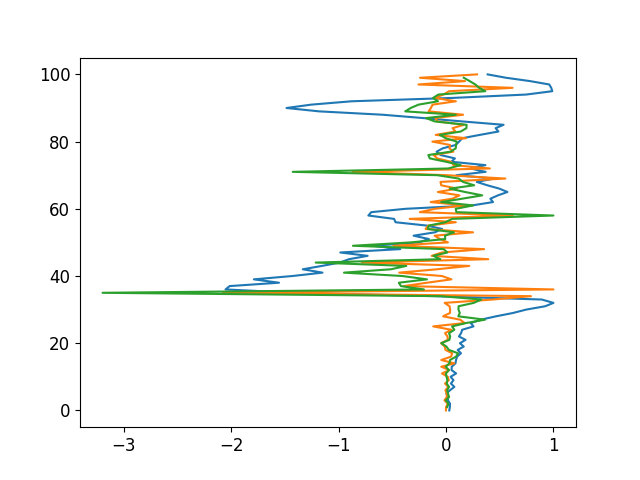

In [21]:
plt.figure()
plt.plot(disk500.T[:,1950+70]/np.max(disk500.T[:,1950+70]),np.arange(101))
plt.plot(icsds[0].get_csd()[:,1950+70]/np.max(icsds[0].get_csd()[:,1950+70]),np.arange(101))
plt.plot(noNeg.T[:,70]/np.max(noNeg.T[:,70]),np.arange(1,100))


In [22]:
icsds[0].get_csd().shape

(101, 3000)

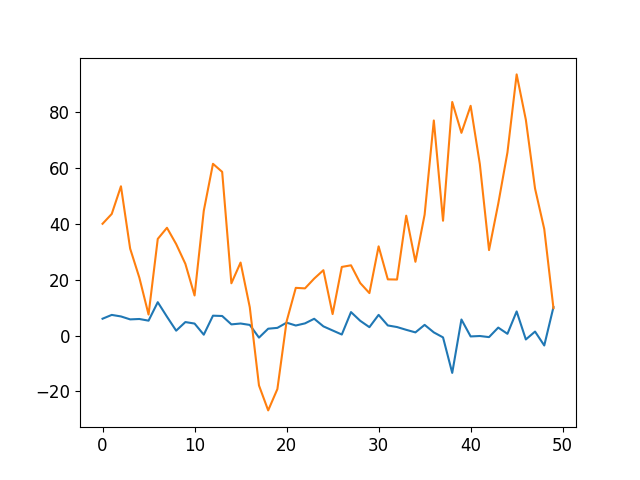

In [23]:
plt.figure()
plt.plot(icsds[0].get_csd()[10,2000:2050])

plt.plot(icsds[0].get_csd()[50,2000:2050])

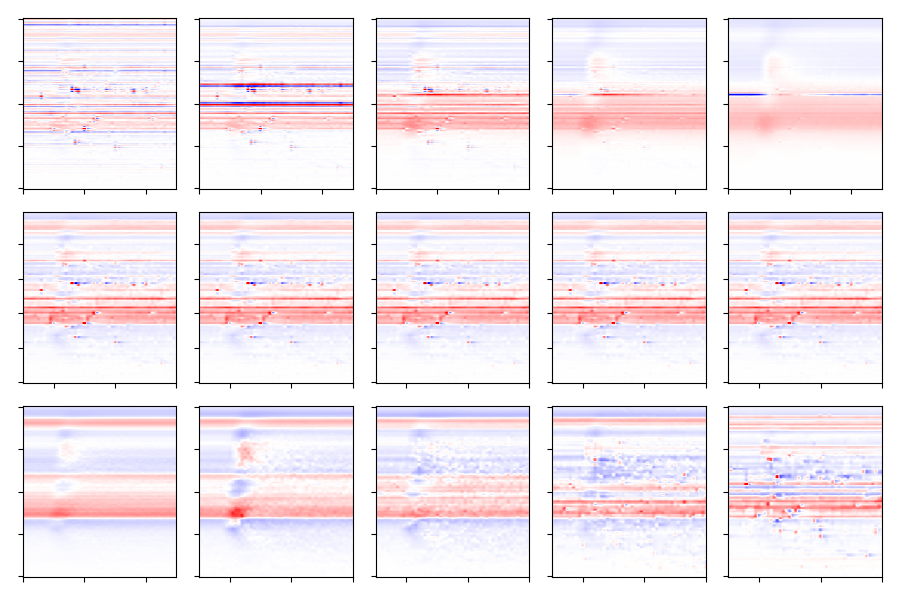

In [24]:
### This cell plots Figure 3 a

fig, axes = plt.subplots(3,5,figsize=(9,6))

for i in range(5):
    plotFig(axes[0][i],icsds[i].get_csd(),xlabels=False)
    plotFig(axes[1][i],noNeg.T,timeLimited=True,xlabels=False)


plotFig(axes[2][0],disk500.T,xlabels=False,timeLimited=False)

plotFig(axes[2][1],disk200.T,xlabels=False,timeLimited=True)

plotFig(axes[2][2],disk100.T,xlabels=False,timeLimited=True)

plotFig(axes[2][3],disk50.T,xlabels=False,timeLimited=True)

plotFig(axes[2][4],disk20.T,xlabels=False,timeLimited=True)

# plotFig(axes[2][4],disk10.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][5],disk5.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][6],disk2.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][7],disk1.T,xlabels=True,timeLimited=True)

plt.savefig('../figures/20um.png',dpi=300)

In [20]:
### This cell calcualtes the correlation between iCSD and objective disk CSD for each of the electrode densities

correlations_500 = []
correlations_200 = []
correlations_100 = []
correlations_50 = []
correlations_20 = []
correlations_10 = []
correlations_5 = []
correlations_2 = []
correlations_1 = []

for i in np.arange(2000,2050):
    correlations_500.append(np.corrcoef(icsds[0].get_csd()[1:-1,i],disk500.T[1:-1,i])[0,1])
    correlations_200.append(np.corrcoef(icsds[1].get_csd()[1:-1,i],disk200.T[1:-1,i-1950])[0,1])
    correlations_100.append(np.corrcoef(icsds[2].get_csd()[1:-1,i],disk100.T[1:-1,i-1950])[0,1])
    correlations_50.append(np.corrcoef(icsds[3].get_csd()[1:-1,i],disk50.T[1:-1,i-1950])[0,1])
    correlations_20.append(np.corrcoef(icsds[4].get_csd()[1:-1,i],disk20.T[1:-1,i-1950])[0,1])
    correlations_10.append(np.corrcoef(icsds[5].get_csd()[:,i],disk10.T[:,i-1950])[0,1])
    correlations_5.append(np.corrcoef(icsds[6].get_csd()[:,i],disk5.T[:,i-1950])[0,1])
    correlations_2.append(np.corrcoef(icsds[7].get_csd()[:,i],disk2.T[:,i-1950])[0,1])
    correlations_1.append(np.corrcoef(icsds[8].get_csd()[:,i],disk1.T[:,i-1950])[0,1])


In [26]:
disk500.shape

(3000, 101)

In [21]:
correlations_noNeg = []

correlations_500_noNeg = []
correlations_200_noNeg = []
correlations_100_noNeg = []
correlations_50_noNeg = []
correlations_20_noNeg = []
correlations_10_noNeg = []
correlations_5_noNeg = []
correlations_2_noNeg = []
correlations_1_noNeg = []

for i in np.arange(2000,2050):
    correlations_noNeg.append(np.corrcoef(icsds[0].get_csd()[1:-1,i],noNeg.T[:,i-1950])[0,1])
    
    correlations_500_noNeg.append(np.corrcoef(disk500.T[1:-1,i],noNeg.T[:,i-1950])[0,1])
    correlations_200_noNeg.append(np.corrcoef(disk200.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_100_noNeg.append(np.corrcoef(disk100.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_50_noNeg.append(np.corrcoef(disk50.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_20_noNeg.append(np.corrcoef(disk20.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_10_noNeg.append(np.corrcoef(disk10.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_5_noNeg.append(np.corrcoef(disk5.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_2_noNeg.append(np.corrcoef(disk2.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])
    correlations_1_noNeg.append(np.corrcoef(disk1.T[1:-1,i-1950],noNeg.T[:,i-1950])[0,1])

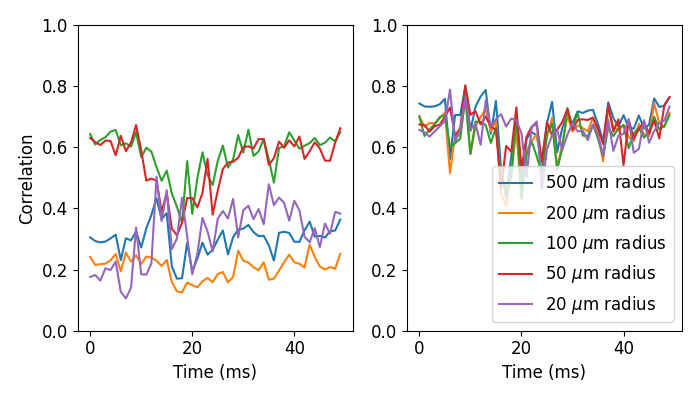

In [32]:
### This cell plots Figure 3 b

plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.plot(correlations_500)
plt.plot(correlations_200)
plt.plot(correlations_100)
plt.plot(correlations_50)
plt.plot(correlations_20)
# plt.plot(correlations_10)
# plt.plot(correlations_5)
# plt.plot(correlations_2)
# plt.plot(correlations_1)

# plt.legend(['iCSD vs oCSD 500','iCSD vs oCSD 200','iCSD vs oCSD 100','iCSD vs oCSD 50', 'iCSD vs oCSD 20'])#,'iCSD vs oCSD 10','iCSD vs oCSD 5','iCSD vs oCSD 2'])

plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.ylim([0,1])
# plt.xlim([15,30])

plt.subplot(1,2,2)
plt.plot(correlations_500_noNeg)
plt.plot(correlations_200_noNeg)
plt.plot(correlations_100_noNeg)
plt.plot(correlations_50_noNeg)
plt.plot(correlations_20_noNeg)
# plt.plot(correlations_10_noNeg)
# plt.plot(correlations_5_noNeg)
# plt.plot(correlations_2_noNeg)
# plt.plot(correlations_1_noNeg)
plt.ylim([0,1])
# plt.xlim([15,30])
plt.legend(['500 $\mu$m radius','200 $\mu$m radius','100 $\mu$m radius','50 $\mu$m radius', '20 $\mu$m radius'])#,'nnCSD vs oCSD 10','nnCSD vs oCSD 5','nnCSD vs oCSD 2'])
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.savefig('../figures/20umcorrelation.png',dpi=300)

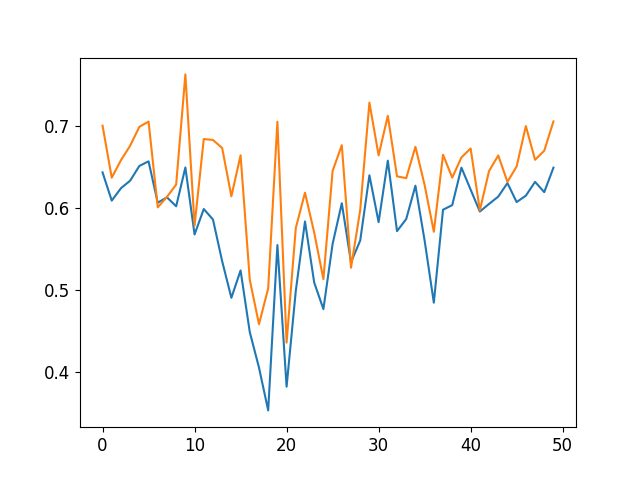

In [34]:
plt.figure()
plt.plot(correlations_100)
plt.plot(correlations_100_noNeg)

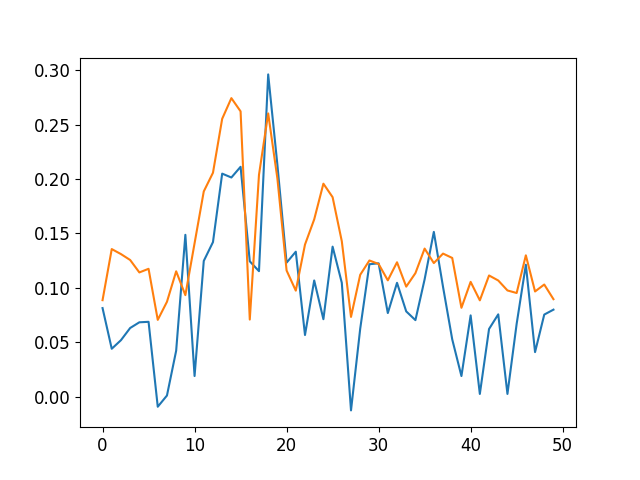

In [48]:
plt.figure()
plt.plot((np.array(correlations_100_noNeg)-np.array(correlations_100))/np.array(correlations_100_noNeg))
plt.plot((np.array(correlations_100_noNeg_lowRes)-np.array(correlations_100_lowRes))/np.array(correlations_100_noNeg_lowRes))

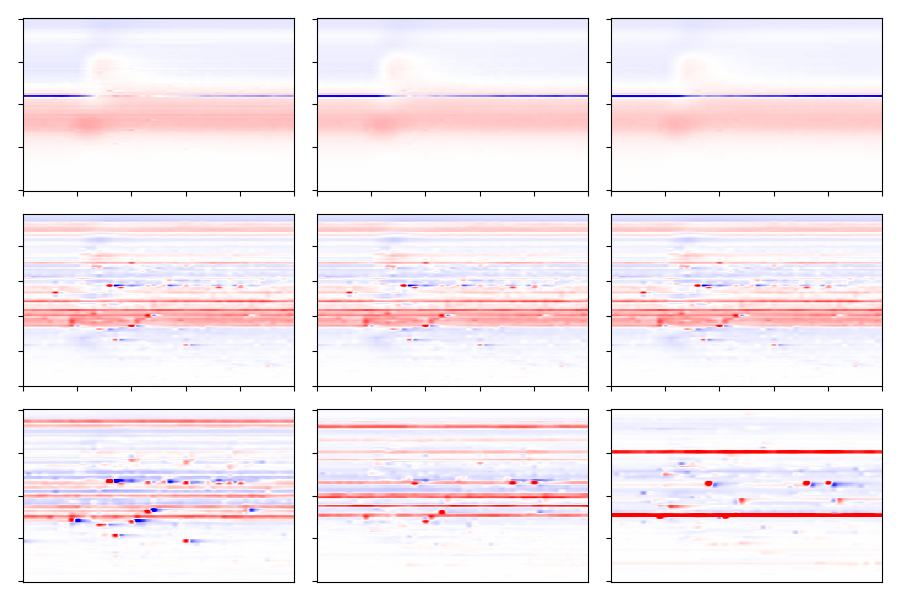

In [22]:
### This cell plots Figure 3 a

fig, axes = plt.subplots(3,3,figsize=(9,6))

for i in np.arange(4,7):
    plotFig(axes[0][i-4],icsds[i].get_csd(),xlabels=False)
    plotFig(axes[1][i-4],noNeg.T,timeLimited=True,xlabels=False)

# plotFig(axes[2][0],disk200.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][1],disk100.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][2],disk50.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][3],disk20.T,xlabels=True,timeLimited=True)

plotFig(axes[2][0],disk10.T,xlabels=True,timeLimited=True)

plotFig(axes[2][1],disk5.T,xlabels=True,timeLimited=True)

plotFig(axes[2][2],disk2.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][7],disk1.T,xlabels=True,timeLimited=True)

plt.savefig('../figures/20um_small.png',dpi=300)

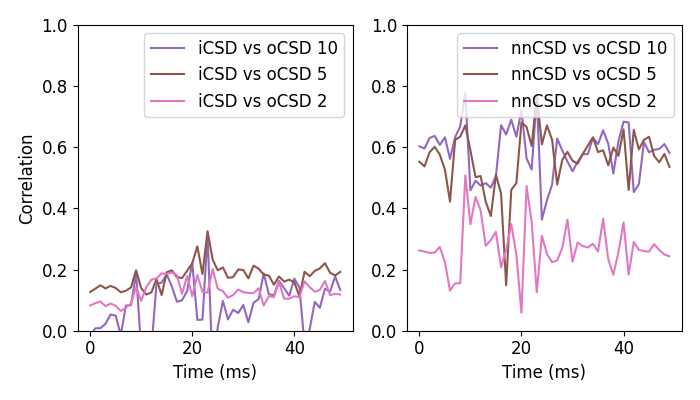

In [23]:
### This cell plots Figure 3 b

plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
# plt.plot(correlations_200)
# plt.plot(correlations_100)
# plt.plot(correlations_50)
# plt.plot(correlations_20)
plt.plot(correlations_10,c='C4')
plt.plot(correlations_5,c='C5')
plt.plot(correlations_2,c='C6')
# plt.plot(correlations_1)

plt.legend(['iCSD vs oCSD 10','iCSD vs oCSD 5','iCSD vs oCSD 2'])

plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.ylim([0,1])

plt.subplot(1,2,2)
# plt.plot(correlations_200_noNeg)
# plt.plot(correlations_100_noNeg)
# plt.plot(correlations_50_noNeg)
# plt.plot(correlations_20_noNeg)
plt.plot(correlations_10_noNeg,c='C4')
plt.plot(correlations_5_noNeg,c='C5')
plt.plot(correlations_2_noNeg,c='C6')
# plt.plot(correlations_1_noNeg)
plt.ylim([0,1])
plt.legend(['nnCSD vs oCSD 10','nnCSD vs oCSD 5','nnCSD vs oCSD 2'])
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.savefig('../figures/20umcorrelation_small.png',dpi=300)

In [41]:
noNeg_lowRes = np.load('../secondDerivLowRes/total.npy')

In [37]:
noNeg_lowRes.shape

(101, 49)

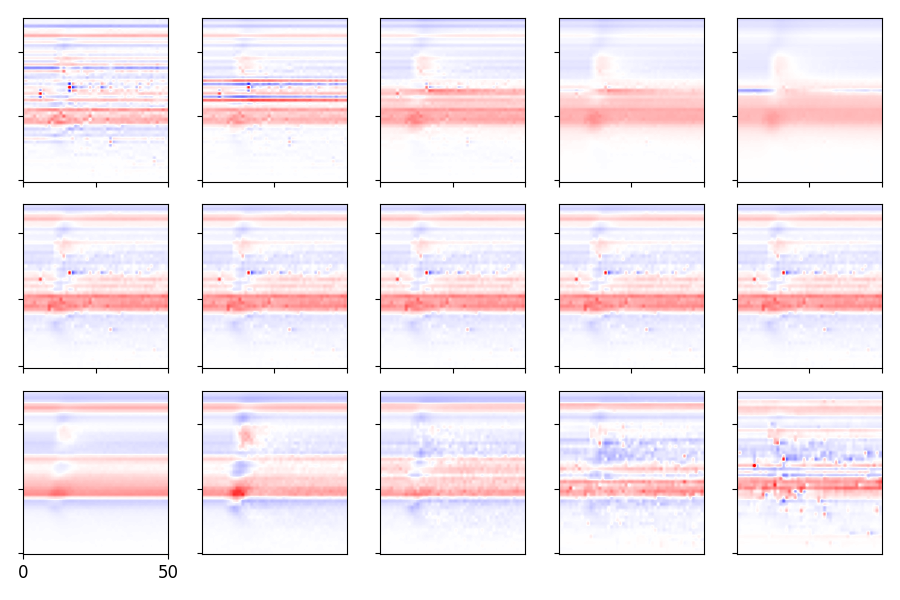

In [42]:
### This cell plots Figure 3 a

fig, axes = plt.subplots(3,5,figsize=(9,6))

for i in range(5):
    plotFig(axes[0][i],icsds_low[i].get_csd(),xlabels=False)
    plotFig(axes[1][i],noNeg_lowRes.T,timeLimited=True,xlabels=False)


plotFig(axes[2][0],disk500_lowRes.T,xlabels=True,timeLimited=False)

plotFig(axes[2][1],disk200_lowRes.T,xlabels=True,timeLimited=True)

plotFig(axes[2][2],disk100_lowRes.T,xlabels=True,timeLimited=True)

plotFig(axes[2][3],disk50_lowRes.T,xlabels=True,timeLimited=True)

plotFig(axes[2][4],disk20_lowRes.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][4],disk10_lowRes.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][5],disk5_lowRes.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][6],disk2_lowRes.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][7],disk1_lowRes.T,xlabels=True,timeLimited=True)
plt.savefig('../figures/40um.png',dpi=300)

In [39]:
noNeg_lowRes.shape

(101, 49)

In [43]:
### This cell calcualtes the correlation between iCSD and objective disk CSD for each of the electrode densities

correlations_500_lowRes = []
correlations_200_lowRes = []
correlations_100_lowRes = []
correlations_50_lowRes = []
correlations_20_lowRes = []
correlations_10_lowRes = []
correlations_5_lowRes = []
correlations_2_lowRes = []
correlations_1_lowRes = []

for i in np.arange(2000,2050):
    correlations_500_lowRes.append(np.corrcoef(icsds_low[0].get_csd()[:,i],disk500_lowRes.T[:,i])[0,1])
    correlations_200_lowRes.append(np.corrcoef(icsds_low[1].get_csd()[:,i],disk200_lowRes.T[:,i-1950])[0,1])
    correlations_100_lowRes.append(np.corrcoef(icsds_low[2].get_csd()[:,i],disk100_lowRes.T[:,i-1950])[0,1])
    correlations_50_lowRes.append(np.corrcoef(icsds_low[3].get_csd()[:,i],disk50_lowRes.T[:,i-1950])[0,1])
    correlations_20_lowRes.append(np.corrcoef(icsds_low[4].get_csd()[:,i],disk20_lowRes.T[:,i-1950])[0,1])
    # correlations_10_lowRes.append(np.corrcoef(icsds_low[0].get_csd()[:,i],disk10_lowRes.T[:,i-1950])[0,1])
    # correlations_5_lowRes.append(np.corrcoef(icsds_low[0].get_csd()[:,i],disk5_lowRes.T[:,i-1950])[0,1])
    # correlations_2_lowRes.append(np.corrcoef(icsds_low[0].get_csd()[:,i],disk2_lowRes.T[:,i-1950])[0,1])
    # correlations_1_lowRes.append(np.corrcoef(icsds_low[0].get_csd()[:,i],disk1_lowRes.T[:,i-1950])[0,1])

In [41]:
icsds_low[0].get_csd().shape

(51, 3000)

In [44]:
correlations_noNeg_lowRes = []

correlations_500_noNeg_lowRes = []
correlations_200_noNeg_lowRes = []
correlations_100_noNeg_lowRes = []
correlations_50_noNeg_lowRes = []
correlations_20_noNeg_lowRes = []
correlations_10_noNeg_lowRes = []
correlations_5_noNeg_lowRes = []
correlations_2_noNeg_lowRes = []
correlations_1_noNeg_lowRes = []

for i in np.arange(2000,2050):
    correlations_noNeg_lowRes.append(np.corrcoef(icsds_low[0].get_csd()[1:-1,i],noNeg_lowRes.T[:,i-1950])[0,1])
    
    correlations_500_noNeg_lowRes.append(np.corrcoef(disk500_lowRes.T[1:-1,i],noNeg_lowRes.T[:,i-1950])[0,1])
    correlations_200_noNeg_lowRes.append(np.corrcoef(disk200_lowRes.T[1:-1,i-1950],noNeg_lowRes.T[:,i-1950])[0,1])
    correlations_100_noNeg_lowRes.append(np.corrcoef(disk100_lowRes.T[1:-1,i-1950],noNeg_lowRes.T[:,i-1950])[0,1])
    correlations_50_noNeg_lowRes.append(np.corrcoef(disk50_lowRes.T[1:-1,i-1950],noNeg_lowRes.T[:,i-1950])[0,1])
    correlations_20_noNeg_lowRes.append(np.corrcoef(disk20_lowRes.T[1:-1,i-1950],noNeg_lowRes.T[:,i-1950])[0,1])
    correlations_10_noNeg_lowRes.append(np.corrcoef(disk10_lowRes.T[1:-1,i-1950],noNeg_lowRes.T[:,i-1950])[0,1])
    correlations_5_noNeg_lowRes.append(np.corrcoef(disk5_lowRes.T[1:-1,i-1950],noNeg_lowRes.T[:,i-1950])[0,1])
    correlations_2_noNeg_lowRes.append(np.corrcoef(disk2_lowRes.T[1:-1,i-1950],noNeg_lowRes.T[:,i-1950])[0,1])
    correlations_1_noNeg_lowRes.append(np.corrcoef(disk1_lowRes.T[1:-1,i-1950],noNeg_lowRes.T[:,i-1950])[0,1])

In [43]:
np.corrcoef(disk200_lowRes.T[:,70],icsds_low[0].get_csd()[:,1950+70])

array([[1.        , 0.53453563],
       [0.53453563, 1.        ]])

In [44]:
np.corrcoef(disk200_lowRes.T[1:-1,70],noNeg_lowRes.T[:,70])

array([[1.       , 0.7362165],
       [0.7362165, 1.       ]])

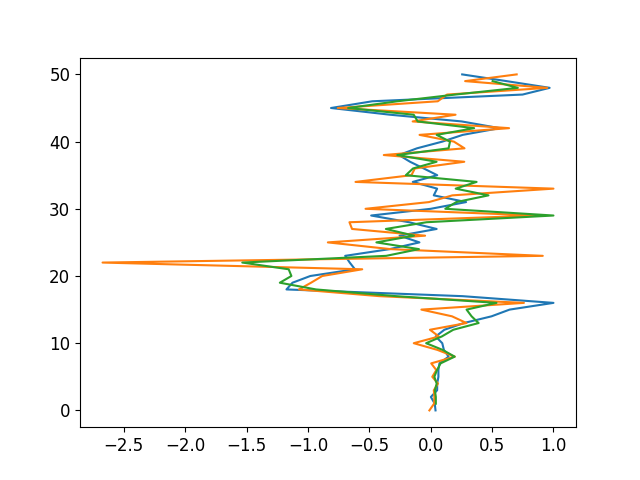

In [45]:
plt.figure()
plt.plot(disk200_lowRes.T[:,70]/np.max(disk200_lowRes.T[:,70]),np.arange(51))
plt.plot(icsds_low[0].get_csd()[:,1950+70]/np.max(icsds_low[0].get_csd()[:,1950+70]),np.arange(51))
plt.plot(noNeg_lowRes.T[:,70]/np.max(noNeg_lowRes.T[:,70]),np.arange(1,50))


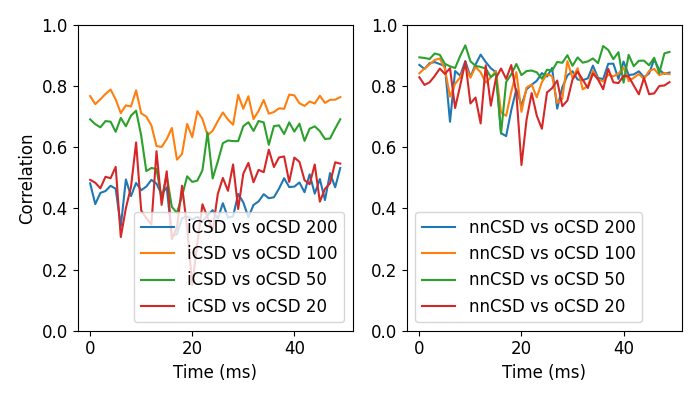

In [45]:
### This cell plots Figure 3 b

plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.plot(correlations_200_lowRes)
plt.plot(correlations_100_lowRes)
plt.plot(correlations_50_lowRes)
plt.plot(correlations_20_lowRes)
# plt.plot(correlations_10_lowRes)
# plt.plot(correlations_5_lowRes)
# plt.plot(correlations_2_lowRes)
# plt.plot(correlations_1)

plt.legend(['iCSD vs oCSD 200','iCSD vs oCSD 100','iCSD vs oCSD 50', 'iCSD vs oCSD 20'])#,'iCSD vs oCSD 10','iCSD vs oCSD 5','iCSD vs oCSD 2'])

plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(correlations_200_noNeg_lowRes)
plt.plot(correlations_100_noNeg_lowRes)
plt.plot(correlations_50_noNeg_lowRes)
plt.plot(correlations_20_noNeg_lowRes)
# plt.plot(correlations_10_noNeg_lowRes)
# plt.plot(correlations_5_noNeg_lowRes)
# plt.plot(correlations_2_noNeg_lowRes)
plt.ylim([0,1])
plt.legend(['nnCSD vs oCSD 200','nnCSD vs oCSD 100','nnCSD vs oCSD 50', 'nnCSD vs oCSD 20'])#,'nnCSD vs oCSD 10','nnCSD vs oCSD 5','nnCSD vs oCSD 2'])
plt.xlabel('Time (ms)')

plt.tight_layout()

plt.savefig('../figures/40umcorrelation.png',dpi=300)

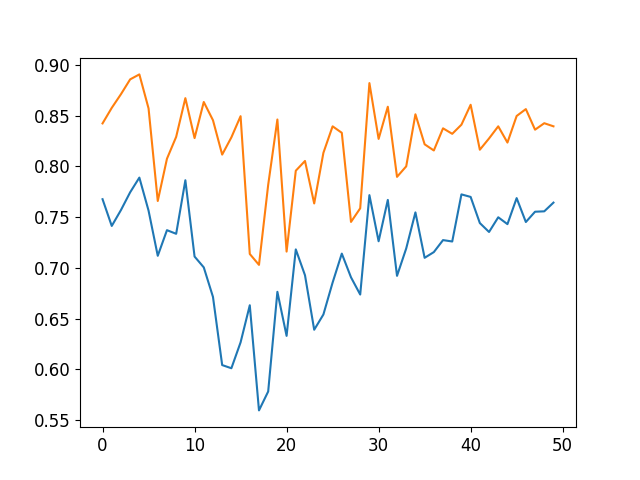

In [46]:
plt.figure()
plt.plot(correlations_100_lowRes)
plt.plot(correlations_100_noNeg_lowRes)

In [42]:
noNeg_verylowRes = np.load('../secondDerivVeryLowRes/total.npy')

In [43]:
noNeg_verylowRes.shape

(101, 24)

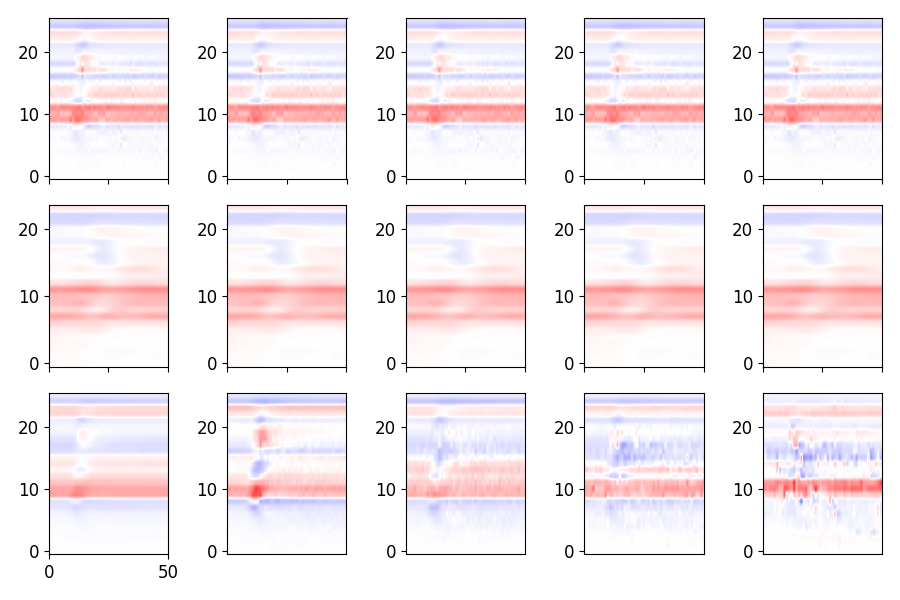

In [44]:
### This cell plots Figure 3 a

fig, axes = plt.subplots(3,5,figsize=(9,6))

for i in range(5):
    plotFig(axes[0][i],icsd_verylow.get_csd(),xlabels=False)
    plotFig(axes[1][i],noNeg_verylowRes.T,timeLimited=True,xlabels=False)


plotFig(axes[2][0],disk500_verylowRes.T,xlabels=True,timeLimited=False)

plotFig(axes[2][1],disk200_verylowRes.T,xlabels=True,timeLimited=True)

plotFig(axes[2][2],disk100_verylowRes.T,xlabels=True,timeLimited=True)

plotFig(axes[2][3],disk50_verylowRes.T,xlabels=True,timeLimited=True)

plotFig(axes[2][4],disk20_verylowRes.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][4],disk10_lowRes.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][5],disk5_lowRes.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][6],disk2_lowRes.T,xlabels=True,timeLimited=True)

# plotFig(axes[2][7],disk1_lowRes.T,xlabels=True,timeLimited=True)
plt.savefig('../figures/u.png',dpi=300)

In [45]:
correlations_500_verylowRes = []
correlations_200_verylowRes = []
correlations_100_verylowRes = []
correlations_50_verylowRes = []
correlations_20_verylowRes = []
correlations_10_verylowRes = []
correlations_5_verylowRes = []
correlations_2_verylowRes = []
correlations_1_verylowRes = []

for i in np.arange(2000,2050):
    correlations_500_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk500_verylowRes.T[:,i])[0,1])
    correlations_200_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk200_verylowRes.T[:,i-1950])[0,1])
    correlations_100_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk100_verylowRes.T[:,i-1950])[0,1])
    correlations_50_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk50_verylowRes.T[:,i-1950])[0,1])
    correlations_20_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk20_verylowRes.T[:,i-1950])[0,1])
    correlations_10_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk10_verylowRes.T[:,i-1950])[0,1])
    correlations_5_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk5_verylowRes.T[:,i-1950])[0,1])
    correlations_2_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk2_verylowRes.T[:,i-1950])[0,1])
    correlations_1_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[:,i],disk1_verylowRes.T[:,i-1950])[0,1])

In [46]:
disk200_verylowRes.shape

(101, 26)

In [47]:
correlations_noNeg_verylowRes = []

correlations_500_noNeg_verylowRes = []
correlations_200_noNeg_verylowRes = []
correlations_100_noNeg_verylowRes = []
correlations_50_noNeg_verylowRes = []
correlations_20_noNeg_verylowRes = []
correlations_10_noNeg_verylowRes = []
correlations_5_noNeg_verylowRes = []
correlations_2_noNeg_verylowRes = []
correlations_1_noNeg_verylowRes = []

for i in np.arange(2000,2050):
    correlations_noNeg_verylowRes.append(np.corrcoef(icsd_verylow.get_csd()[1:-1,i],noNeg_verylowRes.T[:,i-1950])[0,1])
    
    correlations_500_noNeg_verylowRes.append(np.corrcoef(disk500_verylowRes.T[1:-1,i],noNeg_verylowRes.T[:,i-1950])[0,1])
    correlations_200_noNeg_verylowRes.append(np.corrcoef(disk200_verylowRes.T[1:-1,i-1950],noNeg_verylowRes.T[:,i-1950])[0,1])
    correlations_100_noNeg_verylowRes.append(np.corrcoef(disk100_verylowRes.T[1:-1,i-1950],noNeg_verylowRes.T[:,i-1950])[0,1])
    correlations_50_noNeg_verylowRes.append(np.corrcoef(disk50_verylowRes.T[1:-1,i-1950],noNeg_verylowRes.T[:,i-1950])[0,1])
    correlations_20_noNeg_verylowRes.append(np.corrcoef(disk20_verylowRes.T[1:-1,i-1950],noNeg_verylowRes.T[:,i-1950])[0,1])
    correlations_10_noNeg_verylowRes.append(np.corrcoef(disk10_verylowRes.T[1:-1,i-1950],noNeg_verylowRes.T[:,i-1950])[0,1])
    correlations_5_noNeg_verylowRes.append(np.corrcoef(disk5_verylowRes.T[1:-1,i-1950],noNeg_verylowRes.T[:,i-1950])[0,1])
    correlations_2_noNeg_verylowRes.append(np.corrcoef(disk2_verylowRes.T[1:-1,i-1950],noNeg_verylowRes.T[:,i-1950])[0,1])
    correlations_1_noNeg_verylowRes.append(np.corrcoef(disk1_verylowRes.T[1:-1,i-1950],noNeg_verylowRes.T[:,i-1950])[0,1])

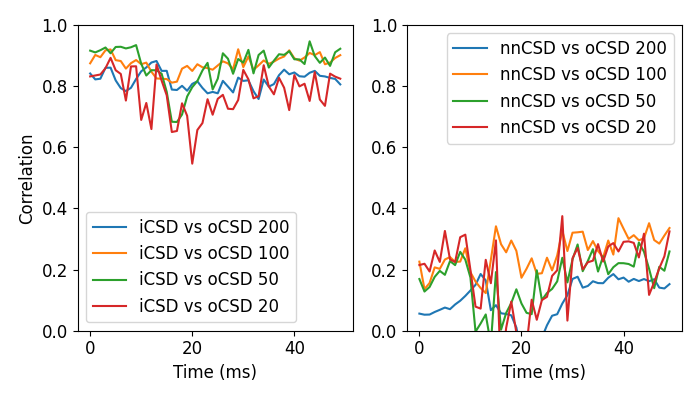

In [48]:
### This cell plots Figure 3 b

plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.plot(correlations_200_verylowRes)
plt.plot(correlations_100_verylowRes)
plt.plot(correlations_50_verylowRes)
plt.plot(correlations_20_verylowRes)
# plt.plot(correlations_10_lowRes)
# plt.plot(correlations_5_lowRes)
# plt.plot(correlations_2_lowRes)
# plt.plot(correlations_1)

plt.legend(['iCSD vs oCSD 200','iCSD vs oCSD 100','iCSD vs oCSD 50', 'iCSD vs oCSD 20'])#,'iCSD vs oCSD 10','iCSD vs oCSD 5','iCSD vs oCSD 2'])

plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(correlations_200_noNeg_verylowRes)
plt.plot(correlations_100_noNeg_verylowRes)
plt.plot(correlations_50_noNeg_verylowRes)
plt.plot(correlations_20_noNeg_verylowRes)
# plt.plot(correlations_10_noNeg_lowRes)
# plt.plot(correlations_5_noNeg_lowRes)
# plt.plot(correlations_2_noNeg_lowRes)
plt.ylim([0,1])
plt.legend(['nnCSD vs oCSD 200','nnCSD vs oCSD 100','nnCSD vs oCSD 50', 'nnCSD vs oCSD 20'])#,'nnCSD vs oCSD 10','nnCSD vs oCSD 5','nnCSD vs oCSD 2'])
plt.xlabel('Time (ms)')

plt.tight_layout()